## Project 3 - Code Notebook for 'Warriors' Subreddit
#### Stephen Strawbridge, Cohort #1019
---

In [1]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import requests
from bs4 import BeautifulSoup

#Import for setting scrape rate
from time import sleep
from random import randint

In [2]:
#Create URL variable for searching by submissions
url = 'https://api.pushshift.io/reddit/search/submission'

In [3]:
#Create params dictionary for 'warriors' subreddit
params = {
    'subreddit' : 'warriors',
    'size' : 100
}

In [4]:
#Create response variable using GET function for the URL and reddit parameters
res = requests.get(url, params)

In [5]:
#Check on status code
res.status_code

200

In [6]:
#Create data variable for storing JSON data
data = res.json()

#Create posts variable to isolate for data
posts = data['data']

In [7]:
#Create time.sleep function to pull data at appropiate rate
#Source code leveraged from fellow classmate, Nolan Arendt

#Set range for 49 so that 100 rows are pulled 49 times to add to the original posts variable, for a total dataframe of 5,000 rows
for count in range(49): 
    sleep(2)
    
    #Create utc so that duplicates are not pulled 
    utc = posts[-1]['created_utc'] 
    
    params = {
    'subreddit' : 'warriors',
    'size' : 100,
    'before' : utc}
    
    data = requests.get(url, params)
    data = data.json()['data']
    posts = posts + data
    

In [8]:
#Observe how many posts we obtain from scraping
len(posts)

5000

In [9]:
#Create dataframe for posts
df_warriors = pd.DataFrame(posts)

In [10]:
#Isolate dataframe for desired features
df_warriors = df_warriors[['subreddit', 'title', 'selftext']]

### Feature Engineering
*Create a 'whole_post' feature that combines values in 'title' and 'selftext' column.*  Before creating this feature, it was noted that there empty spaces in the in the 'selftext' column that were not treated as null values.  In order to ensure there were no empty spaces, the text in the title and selftext columns were combined.  Because the chronological order of words is not relevant for our modeling, combining these texts made sense for a more concise but accurate dataframe to model off of.

In [11]:
#Create 'whole_post' column
df_warriors['whole_post'] = df_warriors['title'] + df_warriors['selftext']

In [12]:
#Check for added feature
df_warriors.head(3)

,subreddit,title,selftext,whole_post
0,warriors,Coming to an Arena near you,,Coming to an Arena near you
1,warriors,Steph Curry NBA Mix~ FLEX (POLO G X JUICE WRLD),,Steph Curry NBA Mix~ FLEX (POLO G X JUICE WRLD)
2,warriors,Two Warriors players test positive for COVID-1...,,Two Warriors players test positive for COVID-1...


### Data Cleaning
---

In [13]:
#Check for null values and data types - some null values in self-text
df_warriors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subreddit   5000 non-null   object
 1   title       5000 non-null   object
 2   selftext    4983 non-null   object
 3   whole_post  4983 non-null   object
dtypes: object(4)
memory usage: 156.4+ KB


In [14]:
#Considering the fact each text column is unique, drop rows with null values
df_warriors = df_warriors.dropna(axis=0, how='any')

In [15]:
#Check that there are no more null values
df_warriors.isnull().sum()

subreddit     0
title         0
selftext      0
whole_post    0
dtype: int64

In [16]:
#Save cleaned csv file separate folder
df_warriors.to_csv('./cleaned_dfs/df_warriors_clean.csv', index=False)

In [ ]:
#Read in saved CSV so that dataframe does not change if/when restarting and running Kernel
df_warriors = pd.read_csv('./cleaned_dfs/df_warriors_clean.csv', index=False)

#### *Warriors dataframe is now clean!*

### Further EDA on Warriors Dataframe
Because this project involves NLP, it is helpful to look at the most commonly occuring words in the dataframe.  The usage of stopwords in input cells below will be utilized in the modeling notebook of the project.

In [25]:
#Adding to list of stopwords, as described in further detail below
#Source code: https://medium.com/@tusharsri/remove-add-stop-words-7e2994c19c67#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjJlMzAyNWYyNmI1OTVmOTZlYWM5MDdjYzJiOTQ3MTQyMmJjYWViOTMiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2MDY3ODYwMTYsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExODAzOTU2ODk0Mjc2MDYwNDEzNCIsImVtYWlsIjoic3RlcGhlbnN0cmF3YnJpZGdlQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJuYW1lIjoiU3RlcGhlbiBTdHJhd2JyaWRnZSIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS0vQU9oMTRHZ041UTZGNk9TRFM3TllUSHdWa0pObTVHQ1FpWkR5THlkMVNHTlA9czk2LWMiLCJnaXZlbl9uYW1lIjoiU3RlcGhlbiIsImZhbWlseV9uYW1lIjoiU3RyYXdicmlkZ2UiLCJpYXQiOjE2MDY3ODYzMTYsImV4cCI6MTYwNjc4OTkxNiwianRpIjoiNTE1ODAwOGRjMTJmYWYzNDVkYTQzYjVjNzdkOWQxMzA1MmEzMjIzYyJ9.Hdn15nX8ADSK9JZBI-y2KgdjVRYZIv3_QIQdco0XA7-t-MEMANDGFpbkffLwlG0CciRwWN5pIgrG2y-9xcdnAQ9gMl0MEBKCLorh4iHWMcCHmLLUnl70yvXrzihlmugq3tKHeOD8JXnjIBsWGcYnoH_FMSwQZ7bAqx_6ldc7Lb_W77dBn1RlIvG2BKaRcu7xkM-bC1-Pru-7OaVw9SMdVqK_TiTeS1kaEgsJAdRWJQKXXHNikBuAnd8dQp9Wp6OC2UAPilHFF79hidc49SQXOdrkstbMDVZOmcQCj8QNe_pF0E47alEK3ClILnF0UUYH5KwyMQC6wey5-ZN_kzmdpA

#Import text package from sklearn
from sklearn.feature_extraction import text

#Create list of new stop words to include in the default English list of stop words
new_stop_words = ['www', 'com', 'https', 'reddit', 'think', 'like', 'index', 'wiki', 'just']
english_stops = (CountVectorizer(stop_words = 'english').get_stop_words)

#Create a final variable of STOP_WORDS to use
STOP_WORDS = text.ENGLISH_STOP_WORDS.union(new_stop_words)

In [26]:
cvec = CountVectorizer(stop_words = STOP_WORDS)
X = df_warriors['whole_post']
cvec.fit(X)
X_trans = cvec.transform(X)

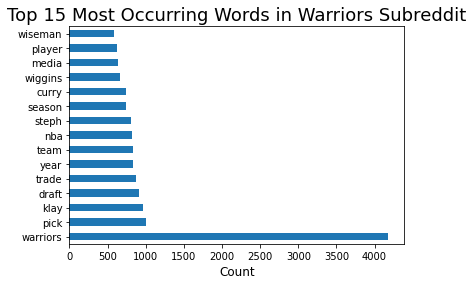

In [27]:
X_df = pd.DataFrame(X_trans.toarray(), 
                           columns=cvec.get_feature_names())

#Observe the top 15 occurring words
plt.title('Top 15 Most Occurring Words in Warriors Subreddit', size=18)
plt.xlabel('Count', size=12)
X_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');